In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = '/home/msy/jupyterProjects/data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
#Visualize a few images
def imshow(inp,title=None):
    """Imshow for Tensor."""
    inp=inp.numpy().transpose((1,2,0))
    mean=np.array([0.485,0.456,0.406])
    std=np.array([0.229,0.224,0.225])

    inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

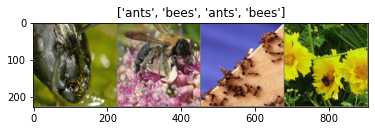

In [6]:
#Get a batch of training data
inputs,classes=next(iter(dataloaders['train']))

#make a grid from batch
out=torchvision.utils.make_grid(inputs)

imshow(out,title=[class_names[x] for x in classes])

In [7]:
#Training the model
def train_model(model,criterion,optimizer,scheduler,num_epochs=40):
    since=time.time()
    
    best_model_wts=copy.deepcopy(model.state_dict())
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()# Set model to training mode
            else:
                model.eval()# Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects=0
            
            #Iterate over data.
            for inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                #forward
                #track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs= model(inputs)
                    _,preds= torch.max(outputs,1)
                    loss= criterion(outputs,labels)
                    # backward + optimize only if in training phase
                    if phase == 'tarin':
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
            if phase =='train':
                scheduler.step()
                
            epoch_loss=running_loss/dataset_sizes[phase]
            epoch_acc=running_corrects.double()/dataset_sizes[phase]
            
            print('{} Loss:{:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            # deep copy the model
            if phase =='val' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [8]:
#Visualizing the model predictions
def visualize_model(model,num_images=6):
    was_training=model.training
    model.eval()
    images_so_far=0
    fig=plt.figure()
    
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs=model(inputs)
            _,preds=torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                images_so_far+=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return model.train(mode=was_training)
                

In [11]:
#Finetuning the convnet
model_ft = models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc=nn.Linear(num_ftrs,2)
model_ft=model_ft.to(device)

criterion=nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)

#Decay LR by a factor of 0.1 every epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

In [12]:
#Train and evaluate
mdoel_ft=train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------
train Loss:0.7547 Acc: 0.5164
val Loss:0.6956 Acc: 0.5556

Epoch 1/24
----------
train Loss:0.7171 Acc: 0.5328
val Loss:0.7054 Acc: 0.5556

Epoch 2/24
----------
train Loss:0.7289 Acc: 0.5123
val Loss:0.6830 Acc: 0.5490

Epoch 3/24
----------
train Loss:0.7388 Acc: 0.5205
val Loss:0.6938 Acc: 0.5556

Epoch 4/24
----------
train Loss:0.7152 Acc: 0.5164
val Loss:0.6938 Acc: 0.5490

Epoch 5/24
----------
train Loss:0.7455 Acc: 0.5164
val Loss:0.6877 Acc: 0.5425

Epoch 6/24
----------
train Loss:0.7502 Acc: 0.5205
val Loss:0.6810 Acc: 0.5490

Epoch 7/24
----------
train Loss:0.7461 Acc: 0.5246
val Loss:0.6942 Acc: 0.5556

Epoch 8/24
----------
train Loss:0.6918 Acc: 0.5328
val Loss:0.6940 Acc: 0.5490

Epoch 9/24
----------
train Loss:0.7089 Acc: 0.5410
val Loss:0.6822 Acc: 0.5490

Epoch 10/24
----------
train Loss:0.7383 Acc: 0.5164
val Loss:0.6858 Acc: 0.5556

Epoch 11/24
----------
train Loss:0.7290 Acc: 0.5287
val Loss:0.6942 Acc: 0.5556

Epoch 12/24
----------
tra

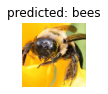

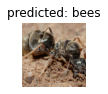

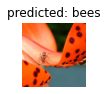

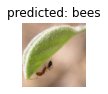

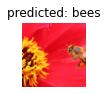

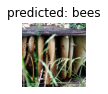

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
visualize_model(model_ft)

In [14]:
#ConvNet 作为固定特征提取器,不更新全连接层前面的参数，更快
model_conv=torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad=False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs=model_conv.fc.in_features
model_conv.fc=nn.Linear(num_ftrs,2)

model_conv=model_conv.to(device)

criterion=nn.CrossEntropyLoss()

#留意只有最后一层的参数才会像以前那样被更新
optimizer_conv=optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)

#以每7次训练缩小0.1的比率减少学习率
exp_lr_scheduler= lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)

In [15]:
#Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss:0.7262 Acc: 0.4877


/home/msy/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


val Loss:0.7186 Acc: 0.5359

Epoch 1/24
----------
train Loss:0.6993 Acc: 0.5082
val Loss:0.7293 Acc: 0.4967

Epoch 2/24
----------
train Loss:0.7197 Acc: 0.5041
val Loss:0.7769 Acc: 0.4771

Epoch 3/24
----------
train Loss:0.7231 Acc: 0.5164
val Loss:0.7158 Acc: 0.5359

Epoch 4/24
----------
train Loss:0.7335 Acc: 0.4836
val Loss:0.7263 Acc: 0.5229

Epoch 5/24
----------
train Loss:0.7344 Acc: 0.4713
val Loss:0.7285 Acc: 0.5359

Epoch 6/24
----------
train Loss:0.7233 Acc: 0.5410
val Loss:0.7322 Acc: 0.5229

Epoch 7/24
----------
train Loss:0.7378 Acc: 0.4549
val Loss:0.7320 Acc: 0.5229

Epoch 8/24
----------
train Loss:0.7366 Acc: 0.4754
val Loss:0.7083 Acc: 0.5359

Epoch 9/24
----------
train Loss:0.7302 Acc: 0.4918
val Loss:0.7293 Acc: 0.5033

Epoch 10/24
----------
train Loss:0.7560 Acc: 0.4549
val Loss:0.7180 Acc: 0.5425

Epoch 11/24
----------
train Loss:0.7184 Acc: 0.5041
val Loss:0.7325 Acc: 0.4967

Epoch 12/24
----------
train Loss:0.7346 Acc: 0.4877
val Loss:0.7271 Acc: 0.53

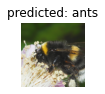

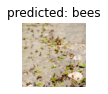

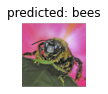

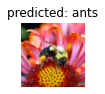

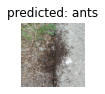

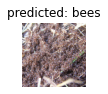

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()